Зададим функцию эластичности `adjust_demand_supply`, которая может учесть изменение цены как для спроса, так и для предложения (курьеры) с помощью коэффициента эластичности.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


SET_POINT = 1.0
BASE_PRICE = 300.0
PED_DEMAND = -1.5
PED_SUPPLY = 1.0

np.random.seed(42)

In [2]:
def adjust_demand_supply(base_price: float, new_price: float, base_value: float,
                         ped: float) -> float:
    '''
    Корректирует спрос/предложение на основе изменений цены, используя ценовую эластичность.

    Parameters:
      base_price (float): Исходная цена продукта или услуги.
      new_price (float): Новая цена продукта или услуги.
      base_value (float): Исходный спрос/предложение при базовой цене.
      ped (float): Предполагаемая средняя ценовая эластичность спроса.

    Returns:
      float: Скорректированный спрос/предложение после изменения цены, всегда неотрицательное значение.

    Примечание:
    - Отрицательное значение PED указывает на то, что значение уменьшается при увеличении цены
      и наоборот.
    '''
    adjusted_value = base_value * (new_price / base_price) ** ped
    return max(adjusted_value, 0)


Ниже приведена авторская реализация PID-контроллера, можете заменить ее на свою.

In [21]:
class PIDController:
    def __init__(self, k_p: float, k_i: float, k_d: float, set_point: float):
        """
        Initializes the PID controller.

        Args:
            k_p (float): The proportional gain coefficient.
            k_i (float): The integral gain coefficient.
            k_d (float): The derivative gain coefficient.
            set_point (float): The desired value.
        """

        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d
        self.set_point = set_point
        self.integral_term = 0
        self.last_error = None

    def get_error(self, process_variable: float) -> float:
        """
        Calculates the error between the setpoint and the process variable.

        Args:
            process_variable (float): The current value of the process.

        Returns:
            float: The calculated error.
        """

        return self.set_point - process_variable

    def get_proportional(self, error: float) -> float:
        """
        Calculates the proportional term of the PID controller.

        Args:
            error (float): The current error.

        Returns:
            float: The proportional term.
        """

        return self.k_p * error

    def get_integral(self, error: float, dt: float) -> float:
        """
        Calculates the integral term of the PID controller.

        Args:
            error (float): The current error.
            dt (float): The time step.

        Returns:
            float: The integral term.
        """

        self.integral_term += error * dt
        return self.k_i * self.integral_term

    def get_derivative(self, error: float, dt: float) -> float:
        """
        Calculates the derivative term of the PID controller.

        Args:
            error (float): The current error.
            dt (float): The time step.

        Returns:
            float: The derivative term.
        """

        if self.last_error is None:
            derivative = 0
        else:
            derivative = (error - self.last_error) / dt
        self.last_error = error
        return self.k_d * derivative

    def get_control(self, process_variable: float, dt: float) -> float:
        """
        Calculates the overall control output of the PID controller.

        Args:
            process_variable (float): The current value of the process.
            dt (float): The time step.

        Returns:
            float: The control output.
        """

        error = self.get_error(process_variable)
        p_term = self.get_proportional(error)
        i_term = self.get_integral(error, dt)
        d_term = self.get_derivative(error, dt)
        return p_term + i_term + d_term


In [4]:
def generate_supply_demand(periods: int = 168) -> tuple[pd.DatetimeIndex, np.array, np.array]:
    # Создаем временной индекс: 7 дней по часам
    hours = pd.date_range(start='2024-01-01', periods=periods, freq='H')

    # ---------- Генерация количества заказов ----------

    # Устанавливаем базовый уровень заказов
    base_orders = 50  # среднее значение заказов

    # Генерируем небольшие случайные колебания вокруг базового уровня
    noise_orders = np.random.normal(0, 5, size=periods)  # умеренная дисперсия

    # Определяем часы, когда происходит всплеск заказов (плохая погода)
    spike_hours = []
    for day in range(7):
        spike_start = day * 24 + 16  # всплеск начинается в 16:00 каждого дня
        spike_hours.extend(range(spike_start, spike_start + 3))  # длится 3 часа

    # Генерируем всплески заказов
    spikes = np.zeros(periods)
    for h in spike_hours:
        spikes[h] = np.random.uniform(10, 15)  # дополнительные заказы во время всплеска

    # Считаем окончательное количество заказов
    orders = base_orders + noise_orders + spikes
    orders = np.clip(orders, 10, 80)  # ограничиваем диапазон значений

    # ---------- Генерация числа активных курьеров ----------

    # Устанавливаем базовый уровень курьеров
    base_couriers = 40  # среднее количество курьеров
    couriers = np.zeros(periods)
    correlation_factor = 0.2  # степень корреляции с заказами
    noise_couriers = np.random.normal(0, 3, size=periods)  # умеренная дисперсия

    for t in range(periods):
        # Вводим небольшую задержку в один час
        if t == 0:
            previous_order = base_orders
        else:
            previous_order = orders[t - 1]

        # Вычисляем желаемое количество курьеров с учетом корреляции и шума
        desired_couriers = base_couriers + (previous_order - base_orders) * correlation_factor
        desired_couriers += noise_couriers[t]

        # Уменьшаем количество курьеров во время всплесков заказов
        if t in spike_hours:
            desired_couriers -= np.random.uniform(5, 10)  # курьеры не хотят работать в плохую погоду

        couriers[t] = desired_couriers

    couriers = np.clip(couriers, 5, 50)  # ограничиваем диапазон значений
    return hours, couriers, orders

Сгенерируем спрос и предложение, и нарисуем их в динамике.

In [5]:
TIME_INDEX, SUPPLY, DEMAND = generate_supply_demand()

C:\Temp\ipykernel_23360\2603524428.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start='2024-01-01', periods=periods, freq='H')


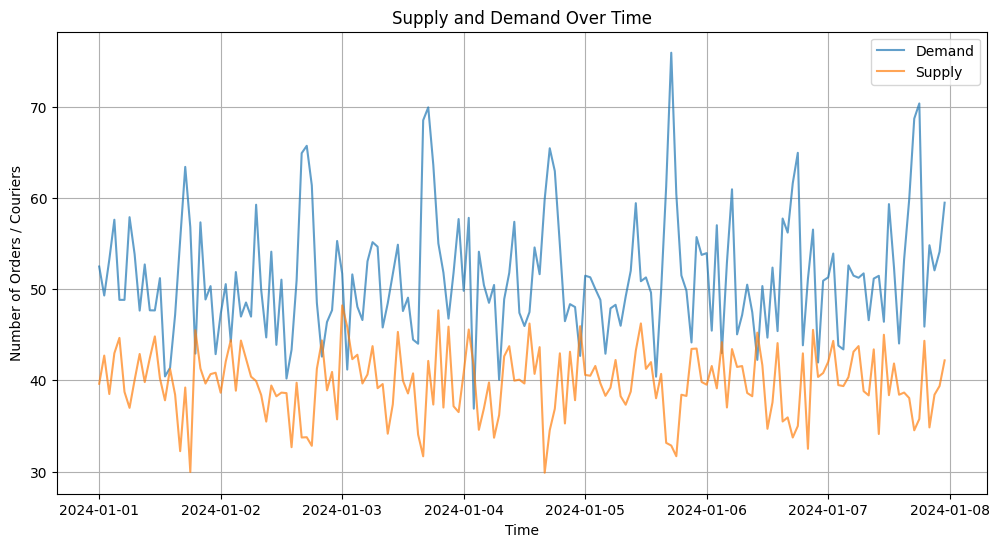

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(TIME_INDEX, DEMAND, label='Demand', alpha=0.7)
plt.plot(TIME_INDEX, SUPPLY, label='Supply', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Number of Orders / Couriers')
plt.title('Supply and Demand Over Time')
plt.legend()
plt.grid(True)
plt.show()

Посмотрим на demand supply rate в динамике для сгенерированных данных.

In [7]:
def plot_dsr(dsr: np.array):
    """
    Plot the Demand Supply Ratio (DSR) over time.

    This function creates a plot comparing the actual DSR to the ideal (set point) DSR.

    Parameters:
    dsr (np.array): An array of DSR values over time.
    """

    plt.figure(figsize=(12, 6))
    plt.plot(TIME_INDEX, np.full_like(dsr, SET_POINT), 'b-', label='Ideal DSR', alpha=0.9)
    plt.plot(TIME_INDEX, dsr, 'r-', label='DSR', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('DSR')
    plt.ylim(-0.5, 2.5)
    plt.title('Demand Supply ratio')
    plt.legend(title=f'MAE: {np.mean(np.abs(dsr - SET_POINT)):.2f}')
    plt.grid(True)
    plt.show()

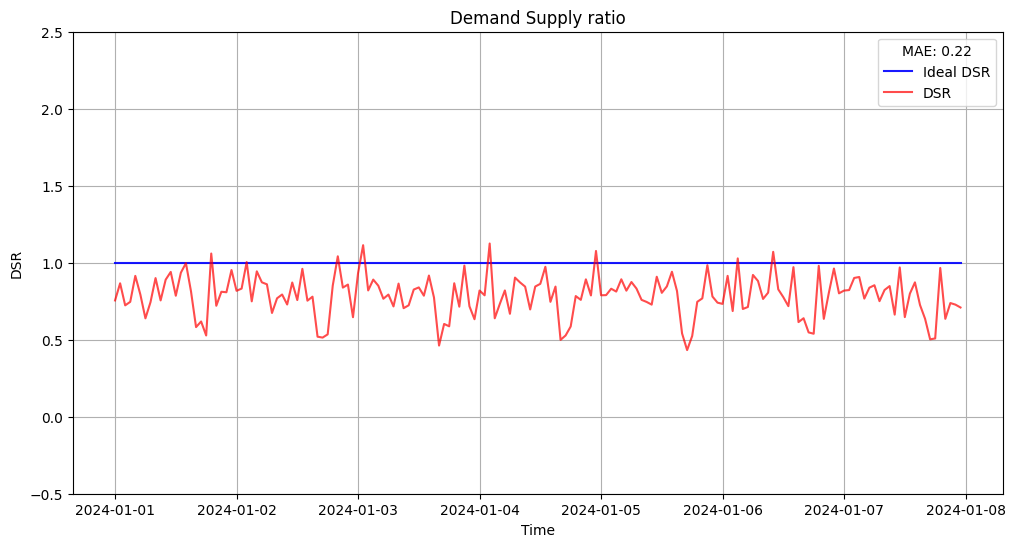

In [8]:
dsr = SUPPLY / DEMAND
plot_dsr(dsr)

In [ ]:
# supply,demand


Смоделируем изменение DSR при корректировке цены ПИД-контроллером и попробуем уменьшить `МАЕ` регулируя коэффициенты `k_p, k_i, k_d`. Если регулировать только `k_p`, а `k_i и k_d` оставить равные нулю, то получится простой Пропорциональный контроллер.

In [9]:
def get_dsr(k_p, k_i, k_d):
    """
    Calculate the Demand Supply Ratio (DSR) using a PID controller.

    This function simulates the adjustment of delivery prices using a PID controller
    to balance supply and demand, returning the resulting DSR over time.

    Parameters:
    k_p (float): Proportional gain of the PID controller
    k_i (float): Integral gain of the PID controller
    k_d (float): Derivative gain of the PID controller

    Global variables used:
    SET_POINT, BASE_PRICE, SUPPLY, DEMAND, PED_DEMAND, PED_SUPPLY

    Returns:
    np.array: An array of DSR values over time
    """

    controller = PIDController(k_p, k_i, k_d, SET_POINT)

    dsr = []
    cv = 0.0  # В начале у нас воздействия на цену
    price = BASE_PRICE  # В начале текущая цена доставки равна базовой

    for s, d in zip(SUPPLY, DEMAND):
        curr_d = adjust_demand_supply(BASE_PRICE, price, d, PED_DEMAND)
        curr_s = adjust_demand_supply(BASE_PRICE, price, s, PED_SUPPLY)
        cv = controller.get_control(s / d, 1)
        price = BASE_PRICE * (1 + cv)
        new_d = adjust_demand_supply(BASE_PRICE, price, curr_d, PED_DEMAND)
        new_s = adjust_demand_supply(BASE_PRICE, price, curr_s, PED_SUPPLY)
        dsr.append(new_s / new_d)

    return np.array(dsr)

In [10]:
def update_plot(k_p, k_i, k_d):
    dsr = get_dsr(k_p, k_i, k_d)
    plot_dsr(dsr)


k_p_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.01, description='k_p:')
k_i_slider = widgets.FloatSlider(value=0, min=0.0, max=0.1, step=0.01, description='k_i:')
k_d_slider = widgets.FloatSlider(value=0, min=0.0, max=0.3, step=0.01, description='k_d:')

interactive_plot = widgets.interactive(update_plot, k_p=k_p_slider, k_i=k_i_slider, k_d=k_d_slider)

display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, description='k_p:', max=1.0, step=0.01), FloatSlider(value=0.0, d…

В рассматриваемом примере интегральная составляющая контроллера заметно ухудшает общую эффективность ПИД-регулятора. Это во многом обусловлено значением параметра dt, равным 1.0, что приводит к чрезмерному накоплению ошибок и, как следствие, избыточной корректировке. Важно отметить, что интегральный компонент обычно наиболее эффективен в ситуациях, где наблюдается устойчивая тенденция (тренд) к увеличению ошибки.

**Задание**
Подберите такие коэффициенты `k_p, k_i, k_d`, чтобы среднего абсолютного отклонения (`MAE`) по показателю `DSR` стало ниже `0.1`. Полученные параметры отправте в качестве решения задания.

In [33]:
def get_dsr(k_p, k_i, k_d):
    controller = PIDController(k_p, k_i, k_d, SET_POINT)
    
    dsr = []
    cv = 0.0 
    price = BASE_PRICE 

    for s, d in zip(SUPPLY, DEMAND):
        curr_d = adjust_demand_supply(BASE_PRICE, price, d, PED_DEMAND)
        curr_s = adjust_demand_supply(BASE_PRICE, price, s, PED_SUPPLY)
        cv = controller.get_control(s / d, 1)
        price = BASE_PRICE * (1 + cv)
        new_d = adjust_demand_supply(BASE_PRICE, price, curr_d, PED_DEMAND)
        new_s = adjust_demand_supply(BASE_PRICE, price, curr_s, PED_SUPPLY)
        dsr.append(new_s / new_d)

    return np.array(dsr)
for i in np.arange(0, 1, 0.01):
    for j in np.arange(0,0.1, 0.01):
        for k in np.arange(0, 0.3, 0.01):
            dsr= get_dsr(i, j, k)
            mae=np.mean(np.abs(dsr - SET_POINT))
            if mae < 0.1:
                print(i,j,k)
            

0.21809657892075682
3.502840953831473
3.323398727042809
6.243119986773154
4.7054741432034675
2.5985320260146003
2.250792374731327
10.183627582178863
6.582270538634261
8.59926333043987
1.4618381548249313
1.5840276359392693
16.222879373673656
4.409614690878416
2.284385282733277
2.2529290426530797
3.5520929786371096
3.4565423639649167
1.7567978287722885
1.4236363909269576
1.4201882563233101
1.9702278840377592
2.0299383103517483
1.3121206225403992
1.249099052754266
1.527067786420012
1.787617358599627
2.8703400075933865
1.3333381803252182
1.0376118035145154
0.9422900115432384
1.4831384548000537
1.1385150229864245
0.8181928721238695
0.7697768758976264
0.7607072231938
0.6978770297376398
0.7147580047555597
0.6946011841518661
0.6976535668599915
0.7154060206399453
0.866189754255814
0.722600992130037
0.718883059578533
0.7329538681609891
0.8754989639541652
1.4825340166750596
0.7656441677493812
0.7456522143920299
0.737354937417908
0.7333684757423059
0.7308645477279241
0.7289890108437573
0.727247513